# Pipelines and oil spills: what data show

Dakota Access Pipeline is no longer an unfamiliar name. The controversy over the pipeline comes from two opposing views. On the one hand, people are of afraid of (water) pollution. On the contrary, the corporation responsible for the pipeline says it's safe. So the question is clear: Is the pipeline really safe? 

It's hard to answer this for a not operational pipeline, but we can look at pipeline incidents data to answer if *pipelines* are safe. Fortunately, the Pipeline and Hazardous Materials Safety (PHMS) Administration provides data on every single pipeline accidents from 1986 to now. The dataset is rich with a lot of raw data showing all kinds of details about the accidents. 

The analysis of the pipeline data is not unprecedented. The New York Times in 2014, created an interactive map of [environmental incidents in North Dakota](http://www.nytimes.com/interactive/2014/11/23/us/north-dakota-spill-database.html?_r=0) from 2006-2014. Back in 2015, [High Country News](http://www.scpr.org/news/2015/06/10/52332/santa-barbara-oil-spill-cleanup-costs-reach-69m-3m/) wrote a piece on crude oil spills after an incident in [Santa Barbara](http://www.scpr.org/news/2015/06/10/52332/santa-barbara-oil-spill-cleanup-costs-reach-69m-3m/) costing more than $62M at the time. Also after an incident in [North Dakota](http://insideenergy.org/2015/01/28/in-north-dakota-oilfield-spill-problems-worsen/), Inside Energy analyzed [wastewater spills in North Dakota](http://insideenergy.org/2015/01/30/wastewater-spills-in-north-dakota-what-the-data-tell-us/). All these articles emphasize that the spills are not as rare as one might think. 

## Objectives

This post is my take on the pipeline incidents. I'm interested in answering these specific questions:

1. How common are spills? 
2. What is their spatial and temporal distributions?
2. What is their scale regarding volume and cost?
2. What are the main causes of spills?
3. What places have a higher risk?

There are tons of other questions to ask, but these are basic questions to understand the problem better. Hopefully, similar studies are done for policy making.

## Dataset and technical details

I am doing the analysis in `Python` using its standard libraries:

* `numpy`
* `pandas`
* `matplotlib`
* `sklearn`

I also use `plotly`, but only for plotting points on the US map. I have customized `matplotlib` style using the recommendations of [this post](http://www.futurile.net/2016/02/27/matplotlib-beautiful-plots-with-style/).

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.neighbors import BallTree
from io import BytesIO
from urllib.request import urlopen
import calendar
from zipfile import ZipFile
import shutil
import os
import time
%matplotlib inline
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Helvetica Neue'
plt.rcParams['font.monospace'] = 'Helvetica Neue'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 120
plt.rcParams['figure.figsize'] = (6,6)
plt.style.use('ggplot')

You can download the dataset from [PHMS website](http://www.phmsa.dot.gov/pipeline/library/data-stats/flagged-data-files) with `xlsx` format.  The dataset is broken into different time periods. Here I only focus on the data from 2010-2016 (filename is `hl2010toPresent`, converted to `CSV` format). Although, many incidents in 2016 are not reported yet. This data contains massive details of each incident (having 255 columns for each record shows this!). I only select a few columns and rename them to be more descriptive:

* Year 
* Location (longitude and latitude)
* Commodity type
* The released volume (in barrels)
* State
* Release type
* Whether water was contaminated
* Total cost (in 1984 dollars)
* Cause

I make a few changes in the dataset to make it more approachable:

* The cost comes in 1984 dollar. According to [this website](http://www.in2013dollars.com/1984-dollars-in-2016?amount=1), \$1 in 1984 is equal to \$2.3 in 2016. 
* The released volume is in barrels, so I convert it to gallons which I have a better sense of (1 barrel = 42 US gallons).
* The commodity names are long, so I make them shorter.

## Update the dataset
The following code block determines if the laest update was longer than update_period. The default value is 20 days.

In [2]:
def download():
    #download zip file
    dataset_url = 'https://www.phmsa.dot.gov/staticfiles/PHMSA/DownloadableFiles/Pipeline/PHMSA_Pipeline_Safety_Flagged_Incidents.zip'
    dataset_url = 'https://www.phmsa.dot.gov/sites/phmsa.dot.gov/files/data_statistics/pipeline/PHMSA_Pipeline_Safety_Flagged_Incidents.zip'
    shutil.move('./hl2010toPresent.csv', './hl2010toPresent_old.csv')
    with urlopen(dataset_url) as zipresp:
        with ZipFile(BytesIO(zipresp.read())) as zfile:
            zfile.extractall('./temp')
    # make files with right name and extension
    shutil.move(src='./temp/hl2010toPresent.xlsx',dst='./')
    shutil.rmtree('./temp')
    os.remove('./hl2010toPresent_old.csv')
    # convert excel file to CSV, used in analysis
    dataset_excel = pd.read_excel('./hl2010toPresent.xlsx',sheetname=1)
    dataset_excel.to_csv('./hl2010toPresent.csv')
    os.remove('./hl2010toPresent.xlsx')
    
'''
if it was more than update_period days since last updated 
file, download new file, convert it to csv
and remove old files.
'''
number_month_dic = {k: v for k,v in enumerate(calendar.month_abbr)}
update_period=14 #number of days
update=False
filename = "./hl2010toPresent.csv"
if os.path.exists(filename):
    time_modified=os.path.getmtime(filename)
    #print ("Last Modification time:",time_modified)
    time_now = time.time()
    #print ('Current time',time_now)
    # if more than update_period days not updated
    time_diff = time_now-time_modified
    if (time_diff)>update_period*24*3600:
        print ('Updating the dataset...')
        download()
        update=True
        update_date = time.strftime("%b %Y", time.localtime(time_now))
    else:
        time_diff_day = np.floor(time_diff/(24*3600))
        print ('The dataset was last modified {:d} days ago.'.format(int(time_diff_day)))
        print ('No need to update the dataset!')
        update_date = time.strftime("%b %Y", time.localtime(time_modified))
else:
    raise IOError('File does not exist!')

The dataset was last modified 0 days ago.
No need to update the dataset!


In [3]:
usefulcols=["LOCAL_DATETIME","IYEAR","LOCATION_LATITUDE","LOCATION_LONGITUDE",
            "COMMODITY_RELEASED_TYPE","UNINTENTIONAL_RELEASE_BBLS","ONSHORE_STATE_ABBREVIATION",
            "RELEASE_TYPE","WATER_CONTAM_IND","TOTAL_COST_IN84","CAUSE"]

dataset = pd.read_csv("./hl2010toPresent.csv", usecols = usefulcols)

dataset.columns = ["time", "year", "lat", "long", "commodity", "volume","state", "release type", "water","cost","cause"]

dataset['commodity'].unique()
dataset['commodity'].replace(
    {'REFINED AND/OR PETROLEUM PRODUCT (NON-HVL) WHICH IS A LIQUID AT AMBIENT CONDITIONS':'REFINED LIQUIDS',
    'CO2 (CARBON DIOXIDE)': 'CARBON DIOXIDE',
    'HVL OR OTHER FLAMMABLE OR TOXIC FLUID WHICH IS A GAS AT AMBIENT CONDITIONS':'FLAMMABLE GASES',
    'BIOFUEL / ALTERNATIVE FUEL(INCLUDING ETHANOL BLENDS)':'BIOFUEL'
    }
    , inplace=True)

# convert to gallons
dataset['volume'] = 42 * (dataset['volume'].astype(int))

# convert to 2016 dollars
dataset['cost'] = 2.3 * dataset['cost']

# fix states with nan values
def fix_nan_states(df):
    #which rows have nan states
    no_states_incidents = df['state'].isnull()
    if sum(no_states_incidents) == 0:
        return df
    else:
        no_states_incidents_idx = no_states_incidents.nonzero()
        # select the subset that has states
        df_subset = df[~no_states_incidents]
        # points in radians
        X = np.radians(df_subset[['lat','long']])
        Y = np.radians(df[no_states_incidents][['lat','long']])
        tree = BallTree(X, leaf_size=2, metric='haversine')# haversine for distance on sphere
        dist, ind = tree.query(Y.values, k=1)
        df.loc[no_states_incidents,'state'] = df_subset.iloc[ind.reshape(-1)]['state'].values
        return df
dataset = fix_nan_states(dataset)

# save the cleaned dataset in a new file
dataset.to_csv('./hl2010toPresent_cleaned.csv',index=False)

print ('Number of incidents   = %d' %dataset.shape[0])
print ('Total volume released = %.1f million gallons' %(dataset['volume'].sum()/10**6))
print ('Total money spent     = %.1f billion dollars' %(dataset['cost'].sum()/10**9))
dataset.head(5)

Number of incidents   = 3105
Total volume released = 27.9 million gallons
Total money spent     = 3.0 billion dollars


,time,year,lat,long,commodity,volume,state,release type,water,cost,cause
0,2010-02-16 07:42:00,2010,41.94352,-88.23353,REFINED LIQUIDS,0,IL,LEAK,NO,38379.865371,EQUIPMENT FAILURE
1,2010-03-01 11:50:00,2010,37.10847,-100.80037,CARBON DIOXIDE,84,KS,OTHER,NO,4414.659264,OTHER INCIDENT CAUSE
2,2010-02-22 10:38:00,2010,32.22471,-101.40440,FLAMMABLE GASES,42,TX,LEAK,NO,33782.834143,CORROSION FAILURE
3,2010-02-19 06:50:00,2010,40.60860,-74.23990,REFINED LIQUIDS,0,NJ,LEAK,NO,21507.314365,EQUIPMENT FAILURE
4,2010-02-21 12:45:00,2010,31.13284,-101.18974,CRUDE OIL,378,TX,LEAK,NO,21991.543373,CORROSION FAILURE


## Number of spills

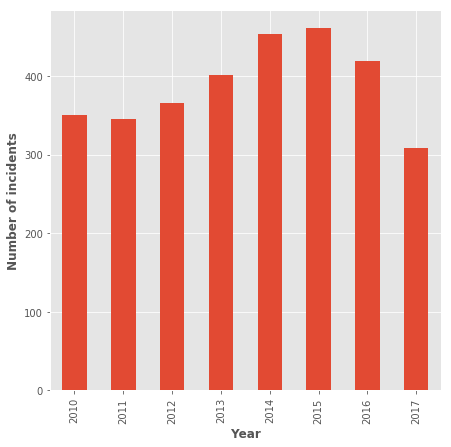

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(7,7))
dataset['year'].value_counts(sort=False).sort_index().plot.bar(ax=ax);
ax.set_xlabel('Year')
ax.set_ylabel('Number of incidents')
plt.show(fig)

## Spread of spills

The first plot shows the volume of the released commodities for all incidents in each year. Both plots are exactly the same, except the marker size is representing two different things. On the left plot, the size shows the cost of the spill. Unsurprisingly, the most costly incidents are those with a high volume usually in the range of $>10^4$.

The right panel, on the other hand, offers an alternative and interesting view (and it looks like they are a bunch of earrings!). The size of each point is proportional to the cost of the spill divided by the release volume. This reveals a very interesting trend: The cost per volume is more for small spills! I don't know exactly why but my guess is the actions need to be taken are partly independent of the spill volume (this is up for debate, of course).

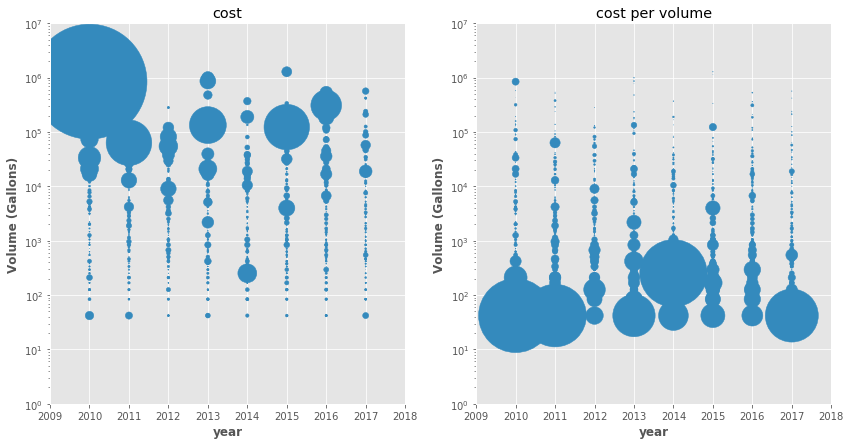

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(14,7))
dataset.plot.scatter(x="year", y="volume",s=dataset.cost/80000,ax=axes[0])
dataset.plot.scatter(x="year", y="volume",s=0.04*dataset.cost/dataset.volume,ax=axes[1])
titles = ['cost','cost per volume']
for i,ax in enumerate(axes):
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    ax.set_yscale('log')
    ax.set_xlim([2009,2018])
    ax.set_ylim([10**0,10**7])
    ax.set_ylabel('Volume (Gallons)')
    ax.set_title(titles[i])
plt.show(fig)

Based on the commodity, the crude oil is the leading commodity that is released. Among 2693 incidents (roughly 1.5 incidents a day) reported from 2010 to October 2016, 1344 incidents involves releasing crude oil followed by refined fluid by 911 incidents. Together they make up ~$\%84$ of the incidents.

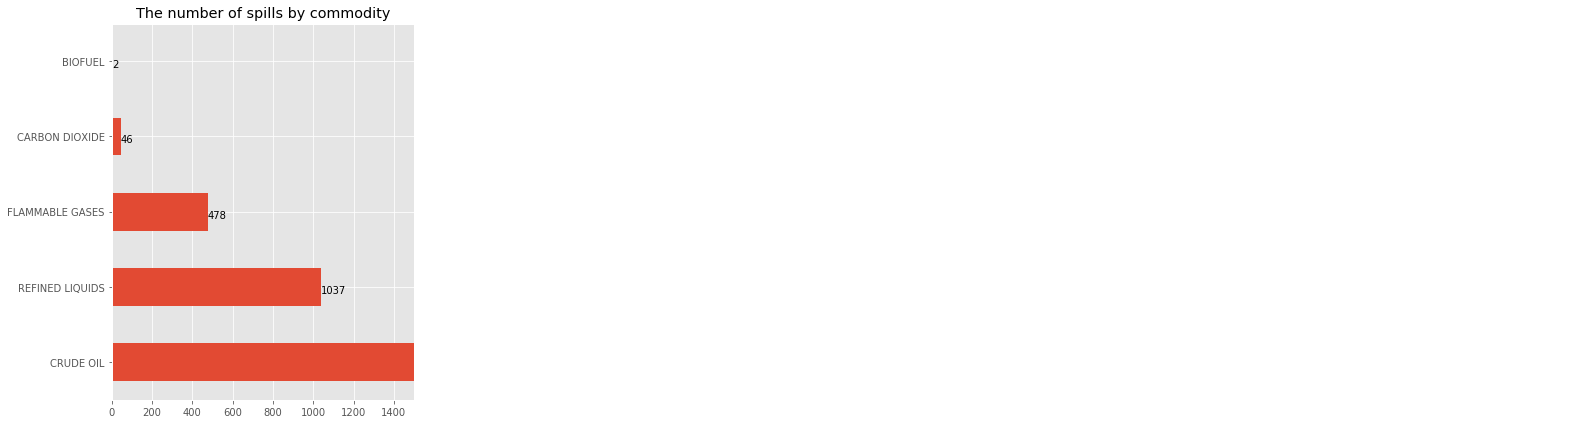

In [6]:
ax = dataset["commodity"].value_counts(sort=True).plot.barh()
ax.set_title("The number of spills by commodity")
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_width()), (1.1*p.get_x()+p.get_width(), p.get_y()+p.get_height()/3 ))
ax.set_xlim(0,1500)
plt.tight_layout()
plt.show()

It is worrying that number of the incidents has been constantly growing. Let's look at the data by year and the reason of spill. Obviously _leak_ is the leading cause and unfortunately constantly number of the leaks is increasing. I see no reason that this trend  stops at this year. Other causes have more or less the same frequency over these years.

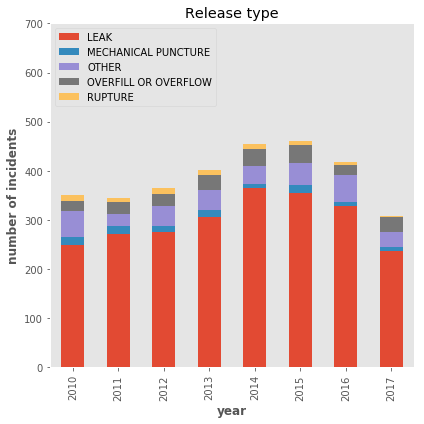

In [7]:
release_year = pd.crosstab(dataset['year'],dataset['release type'])
ax = release_year.plot(kind='bar', stacked=True, grid=False)
ax.set_ylabel("number of incidents")
ax.set_xlabel("year")
ax.legend(loc = 'upper left')
ax.set_ylim(0,700)
ax.set_title('Release type')
plt.tight_layout()
plt.show()

From here on, I will focus on incidents involving crude oil only. The number of such incidents has constantly increased with the exception of 2011. But the released volume follows no such pattern. Also, as dataset clearly mentions, part of the released oil can be recovered but it is not reported in the dataset. In 1344 incidents of crude oil, more than 8.5 million gallons are released.

In [8]:
data = dataset[dataset["commodity"]=="CRUDE OIL"]
data.head()

,time,year,lat,long,commodity,volume,state,release type,water,cost,cause
4,2010-02-21 12:45:00,2010,31.13284,-101.18974,CRUDE OIL,378,TX,LEAK,NO,21991.543373,CORROSION FAILURE
8,2010-02-20 06:30:00,2010,32.47850,-94.86790,CRUDE OIL,336,TX,OVERFILL OR OVERFLOW,YES,117614.823872,EQUIPMENT FAILURE
10,2010-03-01 09:16:00,2010,47.68857,-95.41732,CRUDE OIL,126,MN,OVERFILL OR OVERFLOW,NO,23997.634976,INCORRECT OPERATION
13,2010-03-01 08:10:00,2010,32.48325,-94.83034,CRUDE OIL,8316,TX,RUPTURE,NO,20146.442193,CORROSION FAILURE
16,2010-01-25 11:07:00,2010,29.47000,-90.25444,CRUDE OIL,8484,LA,OVERFILL OR OVERFLOW,YES,838911.034004,EQUIPMENT FAILURE


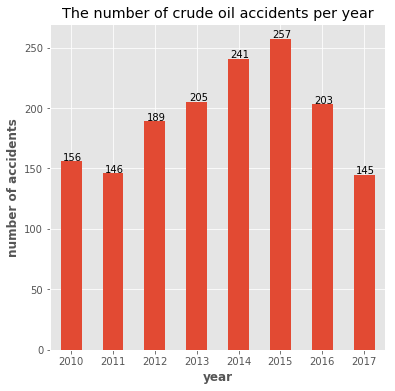

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(6,6))
data["year"].value_counts(sort=False).plot(kind='bar',rot=0,ax=axes)

axes.set_title("The number of crude oil accidents per year")
axes.set_ylabel("number of accidents")
axes.set_xlabel("year")
for p in axes.patches:
    # write number on the bars
    axes.annotate('{:.0f}'.format(p.get_height()), (p.get_x() + p.get_width()/8, p.get_height() * 1.005))
plt.savefig('./incident_oil.png')
plt.show()

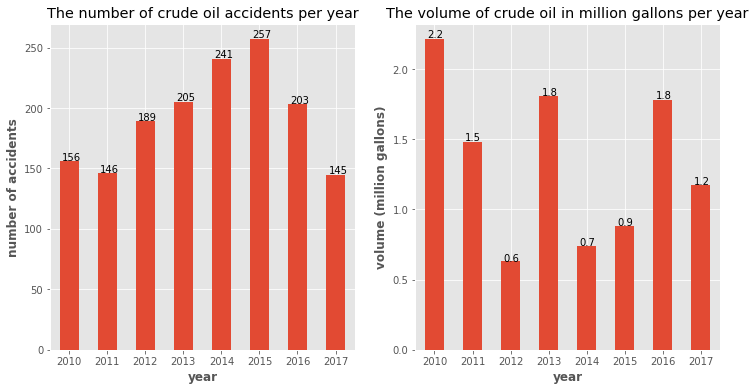

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12,6))
data["year"].value_counts(sort=False).plot(kind='bar',rot=0,ax=axes[0])

axes[0].set_title("The number of crude oil accidents per year")
axes[0].set_ylabel("number of accidents")
axes[0].set_xlabel("year")
for p in axes[0].patches:
    # write number on the bars
    axes[0].annotate('{:.0f}'.format(p.get_height()), (p.get_x() + p.get_width()/8, p.get_height() * 1.005))

(data.groupby(['year'])['volume'].sum()/(10**6)).plot(kind='bar',rot=0,ax=axes[1])
axes[1].set_title("The volume of crude oil in million gallons per year")
axes[1].set_ylabel("volume (million gallons)")
axes[1].set_xlabel("year")
for p in axes[1].patches:
    axes[1].annotate('{:.1f}'.format(p.get_height()), (p.get_x() + p.get_width()/8, p.get_height() * 1.005))
plt.show()

### Which states are dealing with the incidents?

Texas by far has the most spills, followed by Oklahoma, California, and Wyoming. In fact, Texas and Oklahoma deal with more than %51 of the incidents. This is not unexpected as according to [Railroad Commission of Texas](http://www.rrc.state.tx.us/pipeline-safety/): 

> Texas has the largest pipeline infrastructure in the nation, with more than 439,771 miles of pipeline representing about 1/6 of the total pipeline mileage of the entire United States.

Texas, North Dakota and Oklahoma have the highest volume of spills in the nation.

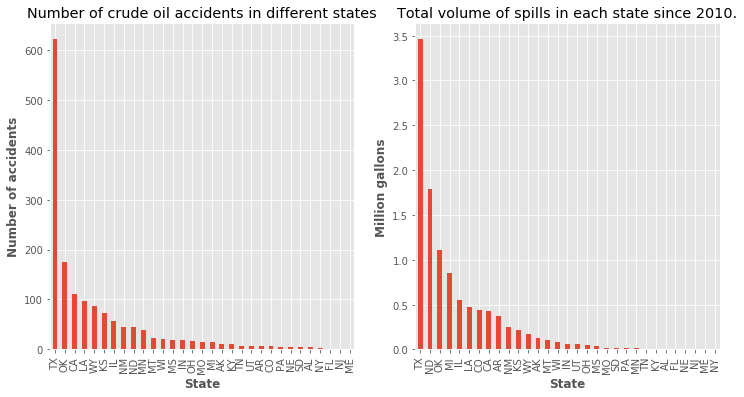

0.5168612191958496

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12,6))

data["state"].value_counts(sort=True).plot(kind='bar',ax=axes[0])
axes[0].set_title("Number of crude oil accidents in different states")
axes[0].set_ylabel("Number of accidents")
axes[0].set_xlabel("State")

grouped = data.groupby(['state'])['volume'].sum()/10**6
grouped.sort_values(ascending=False).plot(kind='bar',ax=axes[1])
axes[1].set_title("Total volume of spills in each state since 2010.")
axes[1].set_ylabel("Million gallons")
axes[1].set_xlabel("State")

plt.show()

# share of the first two states from the incidents
data["state"].value_counts(sort=True,normalize=True)[0:2].sum()

### What is total money spent?

Another factor in a pipeline incident is the cost of each incident. Shown in 2016 dollar, look at the alternating pattern in the cost. This is probably because cleaning and fixing the issue takes a long time (maybe about a year?). Also, the companies are supposed to report the data at the end of fixing and cleaning process, so some incidents are not reported completely. The total reported cost so far has been $2.16 billion since 2010.

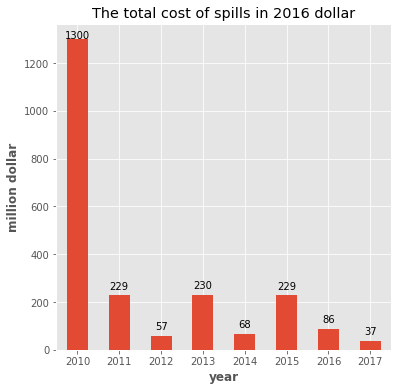

In [12]:
ax = (data.groupby(['year'])['cost'].sum()/10**6).plot(kind='bar',rot=0)
ax.set_title("The total cost of spills in 2016 dollar")
ax.set_ylabel("million dollar")
ax.set_xlabel("year")
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+ p.get_width()/2, p.get_height() * 0.98),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.show()

### Was water contaminated?

Maybe the most concerning aspect of spills is whether they pollute the water. Fortunately, this is often not the case (in %91 of cases). Although, we don't know if those spills happen close to the water or not. Maybe, we have been lucky that pipelines mostly are not crossing close to the water resources.

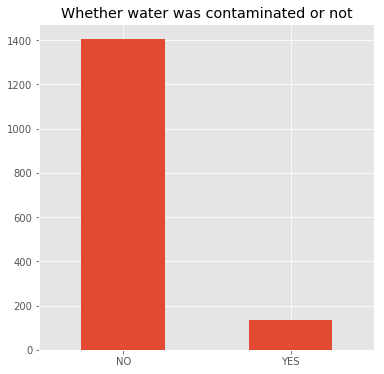

In [13]:
data['water'].value_counts().plot.bar(title="Whether water was contaminated or not",rot=0)
plt.show()

## Geographic distributions

The color intensity represents the number of spills in each states. The color palettes 
on the US map is from [colorbrewer2](http://colorbrewer2.org/). As it was mentioned, Texas is by far the worst state
in terms of number of incididents. 

In [14]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from IPython.display import Image
init_notebook_mode(connected=True)
import plotly.plotly as py

In [15]:
df = pd.DataFrame(data["state"].value_counts(sort=True).reset_index())
df.columns = ["code","counts"]

In [16]:
datax = [ dict(
        type='choropleth',
        autocolorscale = False,
        colorscale=[[0, 'rgb(255,237,160)'],[0.5, 'rgb(254,178,76)'],[1, 'rgb(240,59,32)']],
        locations = df["code"],
        z = df["counts"],
        locationmode = 'USA-states',
        marker = dict(line = dict (color = 'rgb(0,0,0)',width = 1,) ),
        colorbar = dict(title = ""),
        ) ]

layout = dict(
        title = 'The number of spills from 2010-%s' % update_date,  
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showland = True,
            landcolor = "rgb(229, 229, 229)",
            subunitcolor = "rgb(0,5,5)",
            countrycolor = "rgb(0,50,5)",
            countrywidth = 0.5,
            subunitwidth = 0.5        
        ),
    )
    
fig = dict(data=datax, layout=layout)
if update:
    '''If dataset was updated, redo the plot!'''
    iplot( fig, filename='./d3-cloropleth-map',) #image='png'
    py.image.save_as(fig,'./incident_states.png')
else:
    Image('./incident_states.png')

### Incidents on map

Finally, maybe the most informative plot is the spatial distribution of all incidents. The map shows that spills really happen wherever there is a pipeline. Possibly connecting points will show exatcly where pipelines are placed. The color of points is proportional to the released volume. The two large black points are two accidents in North Dakota (July 2013, 865000 gallons, \$20 million) and Michigan (July 2010, 843000 gallons, \$1 billion).

In [17]:
# adjusting size of markers
## if volume is larger than lim, resize the marker
lim = 500000
minsize = lambda x: x/10000 if (x > lim) else 7

datax = [ dict(
        type = 'scattergeo',
        locationmode = 'USA-states',
        lon = data['long'],
        lat = data['lat'],
        text = data['cost'].astype(str),
        mode = 'markers',
        hoverinfo = 'lon+lat+location',
        marker = dict( 
            size = data.volume.apply(minsize),
            symbol = 'circle',
            line = dict(width=1,color='rgba(10, 10, 1)'),
            opacity = 0.9,
            reversescale = False,
            autocolorscale = False,
            colorscale=[[0, 'rgb(240,59,32)'],[0.5, 'rgb(254,178,76)'],[1, 'rgb(0,0,0)']],
            cmin = 0,
            color = data.volume,
            cmax = data['volume'].max(),
            colorbar=dict(title="Gallons"),
        ))]

layout = dict(
        title = 'All crude oil incidents from 2010-%s' %update_date,   
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showland = True,
            landcolor = "rgb(229, 229, 229)",
            subunitcolor = "rgb(0,5,5)",
            countrycolor = "rgb(0,50,5)",
            countrywidth = 0.5,
            subunitwidth = 0.5        
        ),
    )

fig = dict( data=datax, layout=layout )
if update:
    '''If dataset was updated, redo the plot!'''
    iplot( fig, filename='d3-airports' )
    py.image.save_as(fig,'./incident_ditribution.png')
else:
    Image('./incident_ditribution.png')

## Conclusion & future ideas
During the period 2010 to October 2016, more than 8.5 million gallons of crude oil is spilled. The total cost of these spills is well over 2 billion dollars. In one of the worst cases, 843444 gallons was released in Michigan, resulting in a massive 1 billion loss in 2016 dollars and water contamination. In 2016 alone, more than 54 million dollars is the cost of releasing 800000 gallons of crude oil. Although, it is claimed that most incidents happen within the facilities not in the public land [pipeline101 claims](http://www.pipeline101.com/are-pipelines-safe). Although, confirming this needs futhur analysis.

As [Christofer Jones](http://www.christopherfjones.com/), historian of energy at ASU [points out](http://www.zocalopublicsquare.org/2015/06/11/theres-no-such-thing-as-a-spill-proof-way-to-transport-oil/ideas/nexus/): "While it’s true that improved technology and regulation have reduced spills significantly—much like flying today is far safer than in the early years of commercial aviation—the fact remains that there exists no such thing as a spill-proof pipeline. Recognizing this historical reality is crucial to crafting future policy."

Whether this is currently a real priority is another question. At the time that I am writing this rpeort, there are [188 federal and 340 state inspectors](http://phmsa.dot.gov/pipeline/inspections) to inspect "2.7 million miles of pipelines, 148 liquefied natural gas plants, and 7,574 hazardous liquid breakout tanks." 


This quick analysis shows different aspects of the pipeline incidents but many aspects of this dataset is unexplored. Some that I can think of are:
* The number of casualties,
* Whether the pipeline is underground or on ground ,
* possible seasonal/temporal patterns in incidents (One might guess winters are the worst seasons!),
* Whether the spill happened close to the well or far from the pipeline. This is important as some pipelines cross lands close to farming areas and cities.
* How long was the response time?
* What are the most vulnerable areas? Is the vulnerability related to their age?
* How does cost depend on the commodity, volume and cost?
* Categorize spills based on the volume and cost because many spills have really small volumes.

I'll be grateful to hear your ideas, comments, and suggestions!

This repository is also used a [blog post](http://mahdisadjadi/blog/20161203_pipeline/) on my website.